Notes:
- Make sure that all the settings are the same i.e: the optimiser and sigmoided etc.
- Same amount of layers and nodes.
- 

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)

#check the speed of the algorithums agains the direct input -> is lda/pca reduction in accuracy better for the speed?

2.0.0


In [2]:
# code was adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
# Load in data
trainImages = np.load('trnImage.npy')
trainLabels = np.load('trnLabel.npy')

testImages = np.load('tstImage.npy')
testLabels = np.load('tstLabel.npy')

testLabels = testLabels - 1
trainLabels = trainLabels -1

print(trainLabels.shape)

(10000, 1)


In [4]:
def computeFeatures(image):
    # This function computes the HOG features with the parsed hyperparameters and returns the features as hog_feature. 
    # By setting visualize=True we obtain an image, hog_as_image, which can be plotted for insight into extracted HOG features.
    hog_feature, hog_as_image = skimage.feature.hog(image, visualize=True, block_norm='L2-Hys')
    return hog_feature, hog_as_image

In [5]:
# Extracting the images from the data.
trainingData = np.zeros((324, 10000))
testingData = np.zeros((324, 1000))

for i in range(10000):
    features, hog_image = computeFeatures(trainImages[:,:,:,i])
    trainingData[:, i] = features

for x in range(1000):
    features, hog_image = computeFeatures(testImages[:,:,:,x])
    testingData[:, x] = features
    

In [6]:
# Change the shape of the matrix

newTrainingData = trainingData.T
newTestingData = testingData.T

In [7]:
#newTrainingData.shape

# Data straight into NN

In [7]:
# Training the Neural Net with LDA
number_of_classes = 10

start_time = time.time()

# Build our network architecture by stacking layers in a Keras Sequential object.
model = keras.Sequential()

# Create the input layer, this takes an argument of the input data shape (i.e. number of features)
model.add(keras.layers.InputLayer(input_shape=(newTrainingData.shape[1],)))

# Create hidden layers
model.add(keras.layers.Dense(200, activation='sigmoid')) # first layer
#model.add(keras.layers.Dense(100, activation='sigmoid')) # second layer
#model.add(keras.layers.Dense(100, activation='sigmoid')) # third layer

# Create output layer to get predicted class labels.
model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

# Generate a callable keras Model object which contains our architecture.
# This allows us to train and predict our neural network on the datasets.
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc']) #play around with differnt optimizer
# optimizer = "adam"
# Fit our model to the data
history = model.fit(newTrainingData, trainLabels, validation_data=(newTestingData, testLabels), epochs=400, verbose=0)

# Predict probabilities of classes for the testing set.
predicted_probabilities = model.predict(newTestingData)

# Use argmax to get the predicted class label
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(testLabels, predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))
print("--- %s seconds ---" % (time.time() - start_time))

Percentage accuracy on testing set is: 51.30%
--- 139.13041186332703 seconds ---


28:11 -> x3:25 -> 50.70%, x1:24 -> 49.2%, x1:25 -> 50.60%, x1:4 -> 43.10%, x1:100 -> 51.00% 111s, x2:100 -> 47.70% 117s, x3:100 -> 32.90% 124s, x1:4 -> % s, x1:50 -> 50.50% 105s, x2:50 -> 45.10% 110s, x2:100 -> 46.30% 115s, x2:100 -> 47% 118s, x1:4 -> 41.90% 106s, x1:26 -> 50.60% 102s, x1:150 -> 51.50% 132s, x1:200 -> 52.00% 137s, 

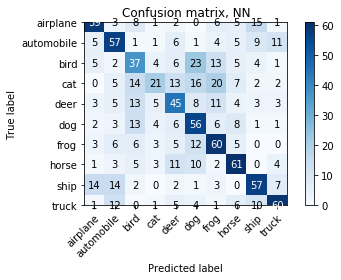

In [8]:
plot_confusion_matrix(testLabels, predicted_labels,classes=trainLabels,
                      title='Confusion matrix, NN' )

plt.show()

## SVM

In [9]:
C = 1 # This is the penalty of the error term (Lecture 8, slide 18). 
SVMmodel = SVC(kernel='poly', C=C) #, gamma=0.1

start_time = time.time()

# Normalise the data based on the training set
svm_normaliser = StandardScaler().fit(newTrainingData)
svm_train_data = svm_normaliser.transform(newTrainingData)
svm_test_data = svm_normaliser.transform(newTestingData)

SVMmodel.fit(svm_train_data, trainLabels.ravel()) #.predict(test_data)
SVMpredicted_labels = SVMmodel.predict(svm_test_data)


accuracy = np.sum(np.equal(testLabels, SVMpredicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))
print("--- %s seconds ---" % (time.time() - start_time))

Percentage accuracy on testing set is: 55.90%
--- 48.771745920181274 seconds ---


28:11:1 -> 30.60%, 2 -> 36.00%, (sigmoid) 1-> 44.40% 2-> 54.90%  (linear) 48.50%, sigmoid -> 55.30%, poly -> 55.90%, poly -> 55.90% 43s, poly -> 55.90% 48s, poly -> 55.90% 47


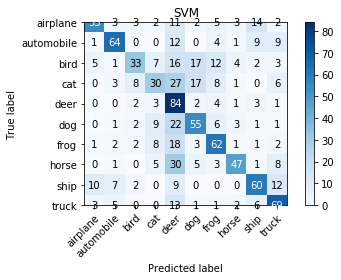

In [10]:
plot_confusion_matrix(testLabels, SVMpredicted_labels, classes=trainLabels,
                      title='SVM')

plt.show()

# PCA into NN

In [17]:
pca = PCA(n_components=100) #n_components = 40

pca.fit(newTrainingData)

pca_train_data = pca.transform(newTrainingData)

#for i in range(9):
#    plt.scatter(pca_train_data[:, i], pca_train_data[:, i+1], c=trainLabels.ravel())
#    plt.xlabel('PC'+ str(i+1))
#    plt.ylabel('PC'+ str(i+2))
#    plt.title('PCA Comparison')
#    plt.show()

pca.fit(newTestingData)

pca_test_data = pca.transform(newTestingData)

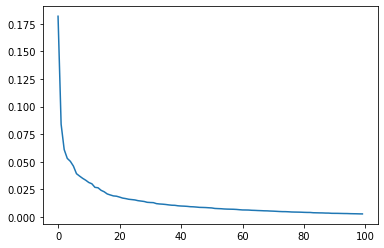

In [18]:
plt.plot(pca.explained_variance_)

In [12]:
# Training the Neural Net with PCA
number_of_classes = 10

start_time = time.time()

# Build our network architecture by stacking layers in a Keras Sequential object.
model = keras.Sequential()

# Create the input layer, this takes an argument of the input data shape (i.e. number of features)
model.add(keras.layers.InputLayer(input_shape=(pca_train_data.shape[1],)))

# Create hidden layers
model.add(keras.layers.Dense(200, activation='sigmoid')) # first layer
#model.add(keras.layers.Dense(5, activation='sigmoid')) # second layer
#model.add(keras.layers.Dense(30, activation='sigmoid')) # third layer

# Create output layer to get predicted class labels.
model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

# Generate a callable keras Model object which contains our architecture.
# This allows us to train and predict our neural network on the datasets.
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc']) #play around with differnt optimizer

# Fit our model to the data
history = model.fit(pca_train_data, trainLabels, validation_data=(pca_test_data, testLabels), epochs=1000, verbose=0)

# Predict probabilities of classes for the testing set.
predicted_probabilities = model.predict(pca_test_data)

# Use argmax to get the predicted class label
pca_predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(testLabels, pca_predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))
print("--- %s seconds ---" % (time.time() - start_time))

Percentage accuracy on testing set is: 21.80%
--- 280.3576910495758 seconds ---


Results:
x3:70 -> 19.10%, x3:20 -> 18.10%, x3:25 -> 20.20%, x3:30 -> 18.20%, x2:20 -> 19.60%, x2:15 -> 18.00% , x1:10 -> 18.20%, x1:5 -> 19.30%, x1:4 -> 17.40%, x2:5 -> 18.00%, 

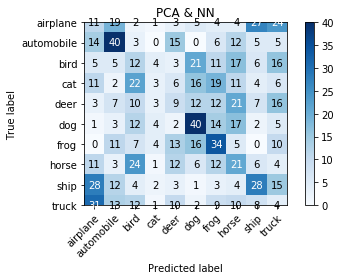

In [15]:
plot_confusion_matrix(testLabels, pca_predicted_labels,classes=trainLabels,
                      title='PCA & NN' )

plt.show()

In [16]:
#predicted_labels.reshape(-1,1)

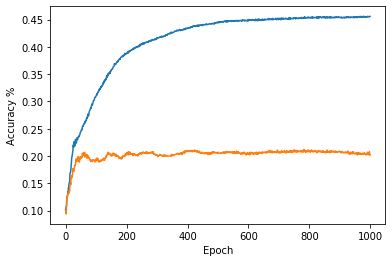

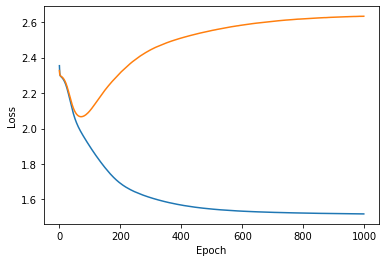

In [17]:
# Plot the training curves for model accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')

# Plot the training curves for the model's loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# PCA into SVM

In [22]:
# PCA into SVM.
pca = PCA(n_components=100) #n_components = 40

pca.fit(newTrainingData)
pca_svm_train_data = pca.transform(newTrainingData)

pca.fit(newTestingData)
pca_svm_test_data = pca.transform(newTestingData)

In [23]:
C = 1 # This is the penalty of the error term (Lecture 8, slide 18). 
pca_svm_model = SVC(kernel='poly', C=C) #, gamma=0.1

start_time = time.time()

# Normalise the data based on the training set
pca_svm_normaliser = StandardScaler().fit(pca_svm_train_data)
pca_svm_train_data = pca_svm_normaliser.transform(pca_svm_train_data)
pca_svm_test_data = pca_svm_normaliser.transform(pca_svm_test_data)

pca_svm_model.fit(pca_svm_train_data, trainLabels.ravel()) #.predict(test_data)
pca_svm_predicted_labels = pca_svm_model.predict(pca_svm_test_data)


accuracy = np.sum(np.equal(testLabels, pca_svm_predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))
print("--- %s seconds ---" % (time.time() - start_time))

Percentage accuracy on testing set is: 18.70%
--- 17.79169201850891 seconds ---


18s 18%, 17s 18.70%, 18s, 18.70%, 

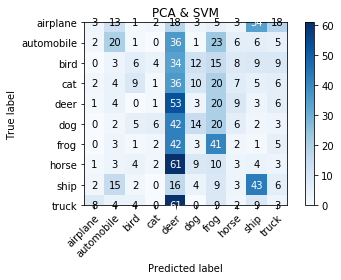

In [24]:
plot_confusion_matrix(testLabels, pca_svm_predicted_labels,classes=trainLabels,
                      title='PCA & SVM' )

plt.show()

## Using LDA and feeding through a NN

In [9]:
LDA = LinearDiscriminantAnalysis() #n_components=9 -> only can have as many labels there are (10)

LDA.fit(newTrainingData, trainLabels.ravel())
lda_new_train_data = LDA.transform(newTrainingData)

#plt.scatter(lda_new_train_data[:, 0], lda_new_train_data[:, 1], c=trainLabels.ravel())
#plt.xlabel('PC1')
#plt.ylabel('PC2')
#plt.title('LDA Comparison')


LDA.fit(newTestingData, testLabels.ravel())
lda_new_test_data = LDA.transform(newTestingData)

#plt.scatter(lda_new_test_data[:, 0], lda_new_test_data[:, 1], c=testLabels.ravel(), marker='v')
#plt.xlabel('PC1')
#plt.ylabel('PC2')
#plt.title('LDA Comparison')
#plt.show()

In [32]:
# Training the Neural Net with LDA
number_of_classes = 10

start_time = time.time()

# Build our network architecture by stacking layers in a Keras Sequential object.
model = keras.Sequential()

# Create the input layer, this takes an argument of the input data shape (i.e. number of features)
model.add(keras.layers.InputLayer(input_shape=(lda_new_train_data.shape[1],)))

# Create hidden layers
model.add(keras.layers.Dense(4, activation='sigmoid')) # first layer
#model.add(keras.layers.Dense(100, activation='sigmoid')) # second layer
#model.add(keras.layers.Dense(21, activation='sigmoid')) # third layer
#model.add(keras.layers.Dense(21, activation='sigmoid')) # forth layer

# Create output layer to get predicted class labels.
model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

# Generate a callable keras Model object which contains our architecture.
# This allows us to train and predict our neural network on the datasets.
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc']) #play around with differnt optimizer

# Fit our model to the data
history = model.fit(lda_new_train_data, trainLabels, validation_data=(lda_new_test_data, testLabels), epochs=400, verbose=0)

# Predict probabilities of classes for the testing set.
predicted_probabilities = model.predict(lda_new_test_data)


# Use argmax to get the predicted class label
lda_predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(testLabels, lda_predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))
print("--- %s seconds ---" % (time.time() - start_time))



Percentage accuracy on testing set is: 53.70%
--- 100.22892594337463 seconds ---


Results: 
28:11 (sigmoid/op=adam) -> x3:70 -> 30.60%, x3:25 -> 36.20%, x2:25 -> 38.00%, x2:15 -> %35.70%, x2:20 -> 35.70%, x3:25 -> 36.70%, x3:15 -> 35.60%, x4:15 -> 38.50%, x4:20 -> 38.60%, x4:25 -> 35.60%, x4:22 -> 36.00%, x4:21 -> 36.60, x1:20 -> 35.30%, x1:10 -> 37.30%, x1:5 -> 48.20%, x1:4 -> 55.50%, x1:3 -> 48.30%, x1:4 -> 55.00% (second attempt), x2:4 -> 52.4%, x2:3 -> 49.00%, x2:6 -> 44.40%, x2:100 -> 31.70%, x1:4 -> 54.90%, x1:100 -> 35.00% 113s, x2:100 -> 32.10% 130s, (op=sgd) x2:100 -> 36.90% 105s, x1:4 -> 54.30% 95s, x1:4(40) -> 53.90% 95s, x1:4 -> 56.30% 121s, x1:4(epoch=500) -> 56.70% 119s, x1:4 (output changed to sigmoid) -> 55.30% 123s, x1:4 -> 54.90% 149s, x1:4 -> 56.10% 125s, x1:26 -> 38.80% 100s, x1:200 -> 37.50% 103s, x1:200 -> 36.90% 105s, x1:4 -> 53.70% 100s, 

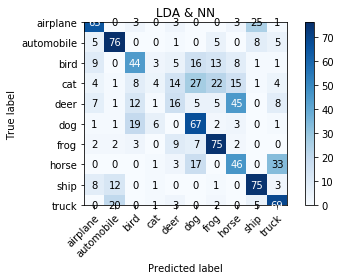

In [33]:
#print(confusion_matrix(testLabels, predicted_labels))
plot_confusion_matrix(testLabels, lda_predicted_labels,classes=trainLabels,
                      title='LDA & NN' )

plt.show()
#data melt

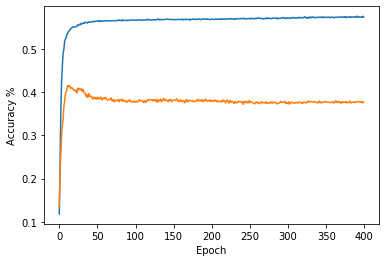

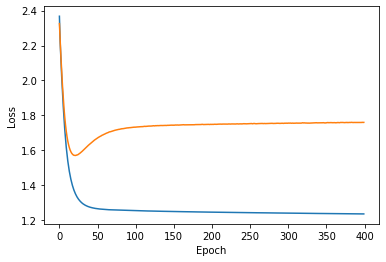

In [24]:
# Plot the training curves for model accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')

# Plot the training curves for the model's loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# LDA into SVM

In [34]:
LDA = LinearDiscriminantAnalysis() #n_components=9 -> only can have as many labels there are (10)

LDA.fit(newTrainingData, trainLabels.ravel())
lda_svm_train_data = LDA.transform(newTrainingData)

LDA.fit(newTestingData, testLabels.ravel())
lda_svm_test_data = LDA.transform(newTestingData)

In [35]:
C = 1 # This is the penalty of the error term (Lecture 8, slide 18). 
lda_svm_model = SVC(kernel='poly', C=C)
start_time = time.time()


# Normalise the data based on the training set
lda_svm_normaliser = StandardScaler().fit(lda_svm_train_data)
lda_svm_train_data = lda_svm_normaliser.transform(lda_svm_train_data)
lda_svm_test_data = lda_svm_normaliser.transform(lda_svm_test_data)

lda_svm_model.fit(lda_svm_train_data, trainLabels.ravel())# .predict(test_data)

lda_svm_predicted_labels = lda_svm_model.predict(lda_svm_test_data)

accuracy = np.sum(np.equal(testLabels, lda_svm_predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))
print("--- %s seconds ---" % (time.time() - start_time))

Percentage accuracy on testing set is: 35.90%
--- 1.532975673675537 seconds ---


48.50%, (linear C1) -> 48.50% 112s, poly -> 35.90% 1.5s, 35.90% 1.5s,  

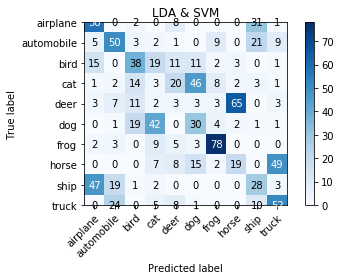

In [36]:
#print(confusion_matrix(testLabels, predicted_labels))
plot_confusion_matrix(testLabels, lda_svm_predicted_labels,classes=trainLabels,
                      title='LDA & SVM' )

plt.show()

# PCA into LDA into SVM

In [37]:
# PCA
pca = PCA(n_components=100) #n_components = 40

#Training data
pca.fit(newTrainingData)
pca_lda_train_data = pca.transform(newTrainingData)

#Testing Data
pca.fit(newTestingData)
pca_lda_test_data = pca.transform(newTestingData)

In [38]:
#Training Data
LDA.fit(pca_lda_train_data, trainLabels.ravel())
pca_lda_train_data = LDA.transform(pca_lda_train_data)

#Testing Data
LDA.fit(pca_lda_test_data, testLabels.ravel())
pca_lda_test_data = LDA.transform(pca_lda_test_data)

In [39]:
C = 1 # This is the penalty of the error term (Lecture 8, slide 18). 
pca_lda_svm_model = SVC(kernel='poly', C=C, gamma=0.1)

start_time = time.time()

# Normalise the data based on the training set
pca_lda_svm_normaliser = StandardScaler().fit(pca_lda_train_data)
pca_lda_svm_train_data = pca_lda_svm_normaliser.transform(pca_lda_train_data)
pca_lda_svm_test_data = pca_lda_svm_normaliser.transform(pca_lda_test_data)

pca_lda_svm_model.fit(pca_lda_svm_train_data, trainLabels.ravel())# .predict(test_data)

pca_lda_svm_predicted_labels = pca_lda_svm_model.predict(pca_lda_svm_test_data)

accuracy = np.sum(np.equal(testLabels, pca_lda_svm_predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))
print("--- %s seconds ---" % (time.time() - start_time))

Percentage accuracy on testing set is: 24.20%
--- 1.6357252597808838 seconds ---


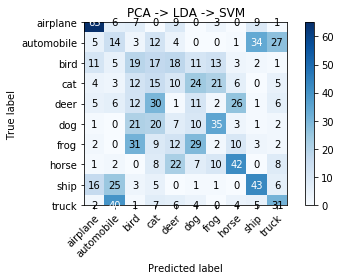

In [40]:
plot_confusion_matrix(testLabels, pca_lda_svm_predicted_labels, classes=trainLabels,
                      title='PCA -> LDA -> SVM')

plt.show()

(sigmoid) 55.30%, (linear) 37.90% 

# PCA into LDA into NN

In [7]:
# PCA
pca = PCA(n_components=100) #n_components = 40

#Training data
pca.fit(newTrainingData)
nn_pca_lda_train_data = pca.transform(newTrainingData)

#Testing Data
pca.fit(newTestingData)
nn_pca_lda_test_data = pca.transform(newTestingData)

In [10]:
#Training Data
LDA.fit(nn_pca_lda_train_data, trainLabels.ravel())
nn_pca_lda_train_data = LDA.transform(nn_pca_lda_train_data)

#Testing Data
LDA.fit(nn_pca_lda_test_data, testLabels.ravel())
nn_pca_lda_test_data = LDA.transform(nn_pca_lda_test_data)

In [11]:
# Training the Neural Net with LDA
number_of_classes = 10

start_time = time.time()

# Build our network architecture by stacking layers in a Keras Sequential object.
model = keras.Sequential()

# Create the input layer, this takes an argument of the input data shape (i.e. number of features)
model.add(keras.layers.InputLayer(input_shape=(nn_pca_lda_train_data.shape[1],)))

# Create hidden layers
model.add(keras.layers.Dense(200, activation='sigmoid')) # first layer
#model.add(keras.layers.Dense(50, activation='sigmoid')) # second layer
#model.add(keras.layers.Dense(21, activation='sigmoid')) # third layer
#model.add(keras.layers.Dense(21, activation='sigmoid')) # forth layer

# Create output layer to get predicted class labels.
model.add(keras.layers.Dense(number_of_classes, activation='softmax'))

# Generate a callable keras Model object which contains our architecture.
# This allows us to train and predict our neural network on the datasets.
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc']) #play around with differnt optimizer

# Fit our model to the data
history = model.fit(nn_pca_lda_train_data, trainLabels, validation_data=(nn_pca_lda_test_data, testLabels), epochs=500, verbose=0)

# Predict probabilities of classes for the testing set.
predicted_probabilities = model.predict(nn_pca_lda_test_data)



# Use argmax to get the predicted class label
nn_pca_lda_predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(testLabels, nn_pca_lda_predicted_labels.reshape(-1,1)))/ 1000 * 100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))
print("--- %s seconds ---" % (time.time() - start_time))

Percentage accuracy on testing set is: 25.20%
--- 133.29133582115173 seconds ---


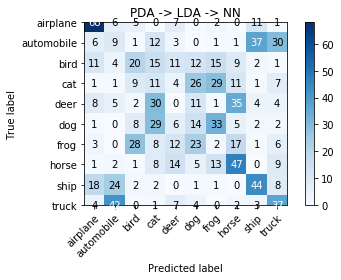

In [12]:
plot_confusion_matrix(testLabels, nn_pca_lda_predicted_labels, classes=trainLabels,
                      title='PDA -> LDA -> NN')

plt.show()

x1:100 -> s,x1:4 -> 